In [417]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio, display
from warnings import warn

from mel import butterworth_filter, pretty_spectrogram, invert_pretty_spectrogram
from mel import create_mel_filter, make_mel, mel_to_spectrogram


class AudioFile:
    """
    Class containing methods to load, manipulate and analyse audio files.
    
    Methods:
        __init__ - fetches the name of an audio file at '../data/raw/nsynth-*'
        load_audio - loads data from the .wav audio file
        plot_audio - plots the audio waveform in the time domain
        play_audio - creates a widget to play that audio
        audio_to_spectrogram - generates an FFT spectrogram from the audio data
        spectrogram_to_audio - converts a spectrogram back to an audio waveform
        plot_spectrogram - plots a spectrogram
        filter_harmonics - filters out all non-harmonic frequencies from the spectrogram
        convolve_spectrogram (experimental) - apply non-continuous 1-D convolution
    """
    
    def __init__(self, dataset='train', instrument='keyboard_acoustic', file_number=27):
        """        
        Args:
            dataset - str - Nsynth dataset folder (train, valid, test)
            instrument - str - ('keyboard_acoustic', 'guitar_acoustic')
            file_number - int - index of the file within the specified dataset 
        """
        data_dir =  Path(f'../data/raw/nsynth-{dataset}/')
        examples = json.load(open(data_dir/'examples.json'))
        instruments = pd.Series(list(examples.keys()))
        file = Path(
            instruments[instruments.str.startswith(instrument)].iloc[file_number] + '.wav'
        )
        self.info = examples[file.stem]
        self.filepath = data_dir/'audio'/file.name
        
#         # Print unique instruments
#         re_find_instrument = partial(re.findall, '^.*?\d')
#         unique_instruments = instruments.apply(re_find_instrument).str[0].str[:-2].unique()
#         print(unique_instruments)

    def load_audio(self, start=0, end=-1, butter=None):
        """
        Load audio .wav file data
        
        Args:
            start - int - when to start the audio clip, in seconds
            end - int - when to end the audio clip, in seconds
            butter - tuple - butterworth filter (low, high, btype)
        """
        self.sampling_rate, self.audio = wavfile.read(self.filepath)
        self.nyquist = self.sampling_rate // 2
        duration = self.audio.shape[0] / self.sampling_rate # in seconds
        # Clip duration
        if end != -1:
            if start < end <= duration:
                end = int(end * self.sampling_rate)
            else:
                warn(f'End set to {duration}')
                end = -1
        if start != 0:
            if 0 < start < duration:
                start = int(start * self.sampling_rate)
            else:
                warn(f'Start set to 0')
                start = 0
        self.audio = self.audio[start:end]
        self.duration = self.audio.shape[0] / self.sampling_rate
        # Bandpass filter
        if butter:
            self.audio = butterworth_filter(self.audio, self.sampling_rate, *butter, order=4)
    
            
    def plot_audio(self):
        """
        Plot the loaded audio waveform
        """
        time = np.linspace(0., self.duration, self.audio.shape[0])
        plt.figure(figsize=(10, 3))
        plt.plot(time, self.audio)
        plt.xlim(time.min(), time.max())
        plt.ylabel('Amplitude')
        plt.xlabel('Time (s)');
        plt.tight_layout()
        plt.show()

    def play_audio(self):
        """
        Create widget which plays audio
        """
        display(Audio(self.audio, rate=self.sampling_rate))
    
    # Spectrograms
    def audio_to_spectrogram(self, time_intervals=1, spec_thresh=4):
        """
        Stolen from: https://timsainburg.com/python-mel-compression-inversion.html

        Args:
            time_intervals: how many time intervals to create a spectrogram for   
            spec_thresh: threshold for spectrograms (lower filters out more noise)
        """
        # FFT params - fft_size is maximised to maximise the frequency domain resolution
        self.time_intervals = time_intervals
        fft_size = (self.audio.shape[0] // 2) * 2
        step_size = fft_size // self.time_intervals
        # Create spectrogram
        self.spectrogram = pretty_spectrogram(
            self.audio.astype("float64"),
            fft_size=fft_size,
            step_size=step_size,
            log=True,
            thresh=spec_thresh,
        )

    def spectrogram_to_audio(self, spectrogram, time_intervals=1):
        """
        Convert spectrogram to audio
        """
        fft_size = spectrogram.shape[1] * 2
        step_size = fft_size // self.time_intervals
        recovered_audio = invert_pretty_spectrogram(
            spectrogram,
            fft_size=fft_size,
            step_size=step_size,
            log=True,
            n_iter=10
        )
        display(Audio(recovered_audio, rate=self.sampling_rate))
        
    def plot_spectrogram(self, spectrogram, title='', max_freq=None, figsize=(10, 6)):
        """
        Plots a spectrogram
        """
        if max_freq is None:
            ylim = -1
            max_freq = self.nyquist
        else:
            ylim = int(self.spectrogram.shape[1] * max_freq / self.nyquist)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        cax = ax.matshow(
            spectrogram.T[:ylim],
            interpolation="nearest",
            aspect="auto",
            cmap=plt.cm.afmhot,
            origin="lower",
            extent = [0, 1, 0, max_freq]
        )
        fig.colorbar(cax)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def filter_harmonics(self, fundamental, neighbour_radius=0):
        """
        Removes all frequency amplitudes and only keeps the harmonics of the fundamental frequency
        
        Args:
            fundamental - int - fundamental frequency
            neighbour_radius - int -  number of neighbouring frequencies to include
        """
        self.spectrogram_harm = np.ones(self.spectrogram.shape) * self.spectrogram.min()
        step = fundamental * self.spectrogram.shape[1] // self.nyquist
        for i in range(neighbour_radius+1):
            self.spectrogram_harm[0, step+i::step] = self.spectrogram[0, step+i::step]
            self.spectrogram_harm[0, step-i::step] = self.spectrogram[0, step-i::step]
    
    # Convolutions
    def _get_harmonic_groups(self):
        """
        Create groups of harmonic frequencies to unwrap the spectrogram
        """
        max_freq = self.spectrogram.shape[1]
        self.harmonic_groups = []
        for freq in list(range(1, max_freq//2, 2)):
            neighbours = []
            i = 0
            next_freq = freq
            while next_freq <= max_freq+1:
                neighbours.append(next_freq-1)
                i+=1
                next_freq = freq * (2**i)
            self.harmonic_groups.append(neighbours)

    def convolve_spectrogram(self):
        """
        Unwrap the spectrogram_slice, apply 1-D conv and wrap it back up
        """
        self._get_harmonic_groups()
        self.spectrogram_conv = np.ones(self.spectrogram.shape)[:, ::2] # * -8
        mask = [1, 1]
        for t in range(self.spectrogram.shape[0]):
            # Time slice to apply convolution to
            spectrogram_slice = self.spectrogram[t]
            # Convolve each group of harmonics
            harmonic_convs = []
            for group in self.harmonic_groups:
                harmonic_amplitudes = spectrogram_slice[group]
                harmonic_convs = np.convolve(mask, harmonic_amplitudes, mode='valid')
                self.spectrogram_conv[t, group[:-1]] = harmonic_convs

# 1. Spectrogram analysis

The nylon guitar:
- Is composed of multiple harmonic sine waves (and some energy around the harmonics)
- Has additional energy in the frequency band below the fundamental frequency
- These lower frequencies don't have any harmonics

The piano:
- Has a lot more energy around the harmonics
- Has more energy around the 3rd and 4th harmonics than the fundamental
- These higher frequencies don't have any harmonics

In [425]:
guitar = AudioFile('test', 'guitar_acoustic', 6)
guitar.fundamental_freq = 110  # A2
guitar.plot_ylim = 10 * fundamental_freq

piano = AudioFile('train', 'keyboard_acoustic', 27)
piano.fundamental_freq = 55  # A1
piano.plot_ylim = 10 * fundamental_freq

## Guitar

--------------
Guitar attack:
--------------


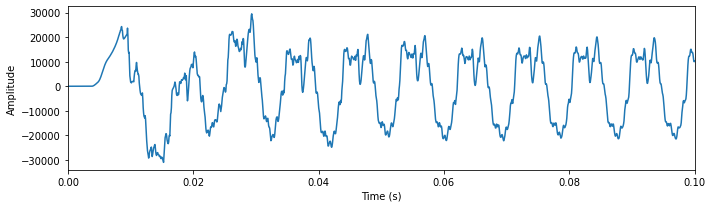

- original sound:


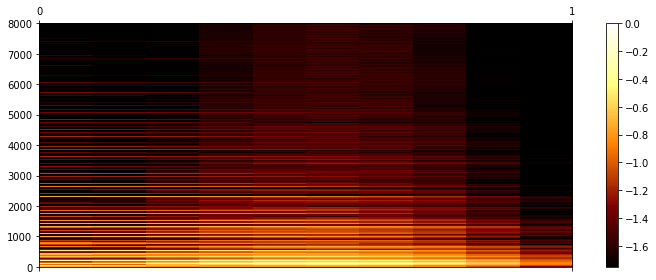

- reconstructed sound:


---------------
Guitar sustain:
---------------


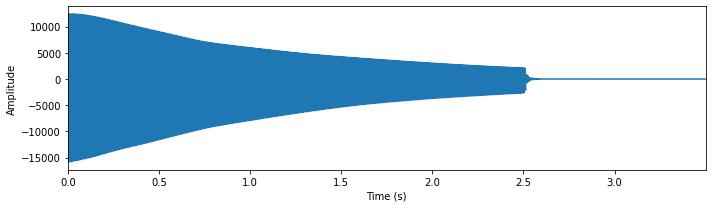

- original sound:


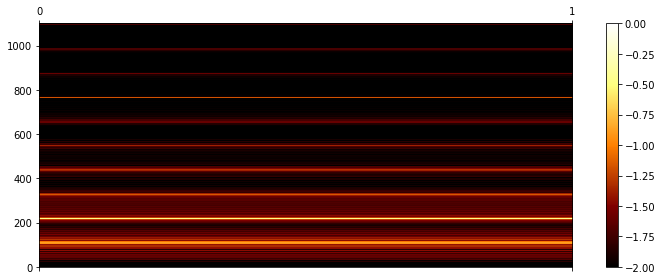

- reconstructed sound:


In [445]:
# Guitar
params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'spec_thresh': 3.5,
     'print': 'Guitar attack:', 'plot_ylim': None},
    {'start': 0.5, 'end': -1, 'time_intervals': 1, 'spec_thresh': 4,
     'print': 'Guitar sustain:', 'plot_ylim': guitar.plot_ylim*2}
]
for p in params:
    # Print
    print('-' * len(p['print']))
    print(p['print'])
    print('-' * len(p['print']))
    # Load and play audio
    guitar.load_audio(p['start'], p['end'])
    guitar.plot_audio()
    print('- original sound:')
    guitar.play_audio()
    # Create spectrogram and reconstruct audio
    guitar.audio_to_spectrogram(p['time_intervals'], p['spec_thresh'])
    guitar.plot_spectrogram(guitar.spectrogram/2, max_freq=p['plot_ylim'], figsize=(10, 4))
    print('- reconstructed sound:')
    guitar.spectrogram_to_audio(guitar.spectrogram)

# Convolve spectrogram
# guitar.convolve_spectrogram()
# guitar.plot_spectrogram(guitar.spectrogram_conv)
# guitar.spectrogram_to_audio(guitar.spectrogram_conv)

## Piano

-------------
Piano attack:
-------------


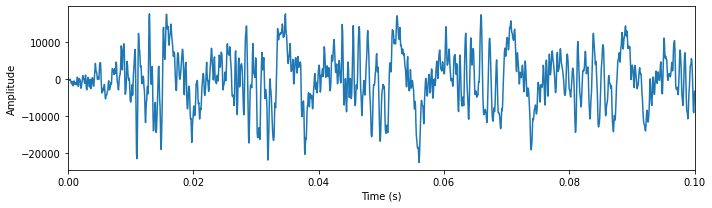

- original sound:


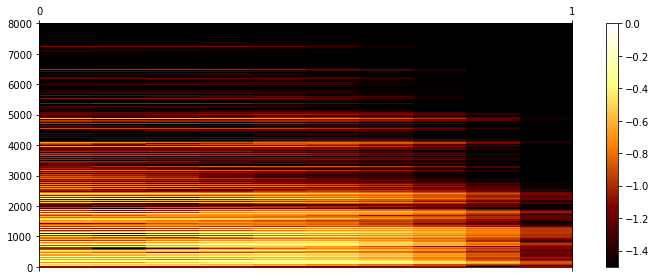

- reconstructed sound:


--------------
Piano sustain:
--------------


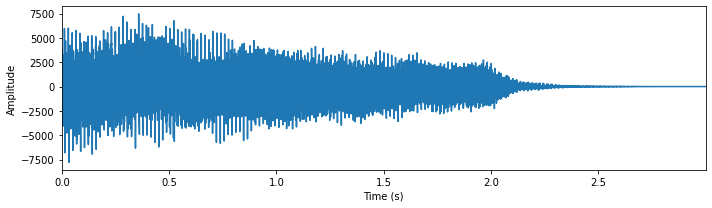

- original sound:


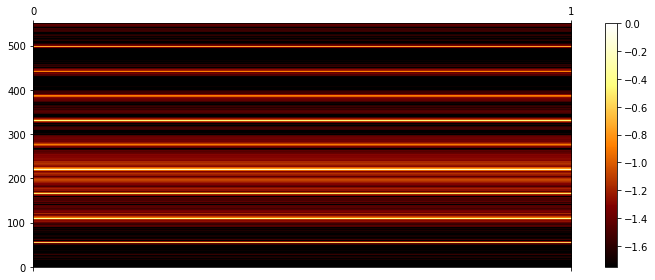

- reconstructed sound:


In [442]:
# Piano
params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'spec_thresh': 3,
     'print': 'Piano attack:', 'plot_ylim': None},
    {'start': 1, 'end': -1, 'time_intervals': 1, 'spec_thresh': 3.5,
     'print': 'Piano sustain:', 'plot_ylim': piano.plot_ylim}
]
for p in params:
    # Print
    print('-' * len(p['print']))
    print(p['print'])
    print('-' * len(p['print']))
    # Load and play audio
    piano.load_audio(p['start'], p['end'])
    piano.plot_audio()
    print('- original sound:')
    piano.play_audio()
    # Create spectrogram and reconstruct audio
    piano.audio_to_spectrogram(p['time_intervals'], p['spec_thresh'])
    piano.plot_spectrogram(piano.spectrogram/2, max_freq=p['plot_ylim'], figsize=(10, 4))
    print('- reconstructed sound:')
    piano.spectrogram_to_audio(piano.spectrogram)

# Convolve spectrogram
# piano.convolve_spectrogram()
# piano.plot_spectrogram(piano.spectrogram_conv)
# piano.spectrogram_to_audio(piano.spectrogram_conv)

# 2. Post-filter analysis

Applying a lowpass filter which removes frequencies above the 2nd harmonic:

- The guitar sounds roughly the same (just a lowpass version)
- The piano sounds very different (almost like the guitar now)


This shows:

- That a guitar note has a lot of energy in the lower harmonics
- By contrast, the piano note has a lot of energy in its upper harmonics

## Guitar

No filter:


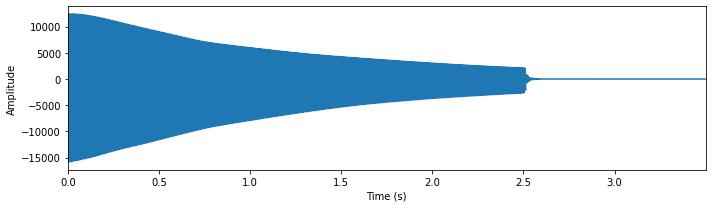

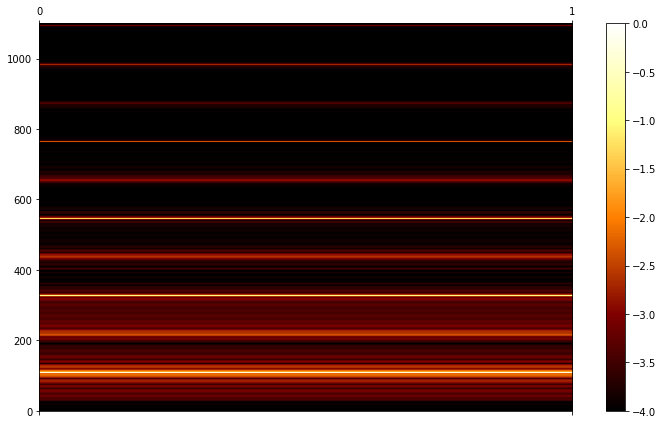

Low-pass filter:


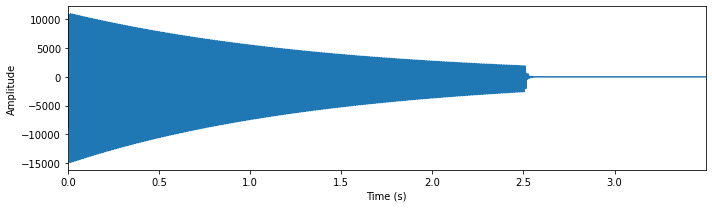

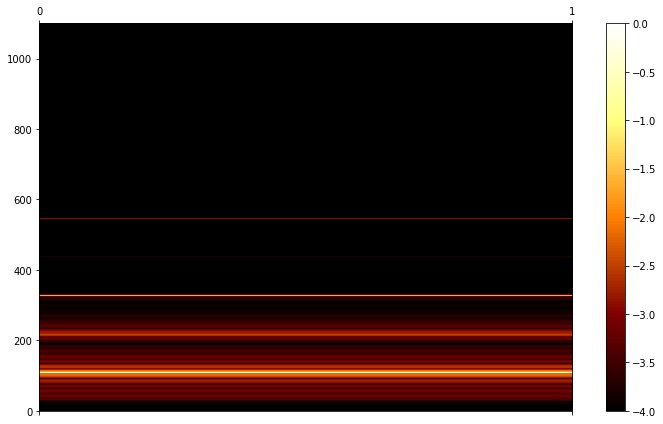

In [413]:
print('No filter:')
# Load and play audio
guitar.load_audio(start=0.5)
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, max_freq=max_freq)

print('Low-pass filter:')
# Load and play audio - with lowpass filter
guitar.load_audio(start=0.5, butter=(0, 220, 'lowpass'))
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, max_freq=max_freq)

## Piano

No filter


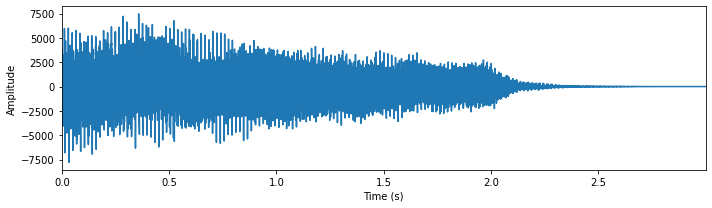

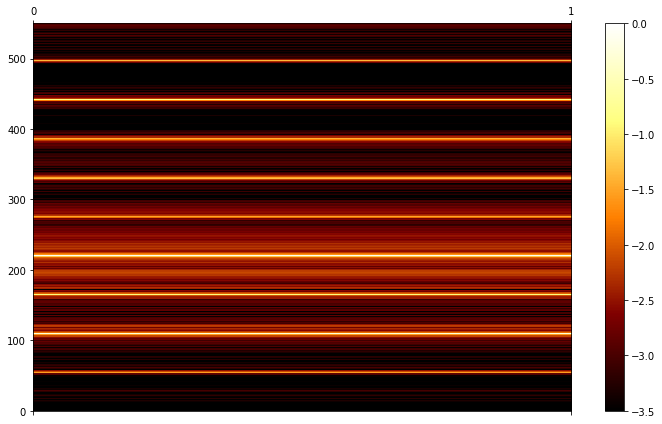

Low-pass filter:


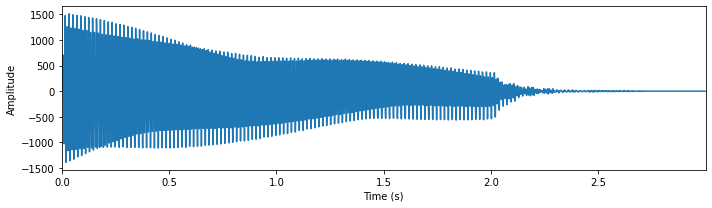

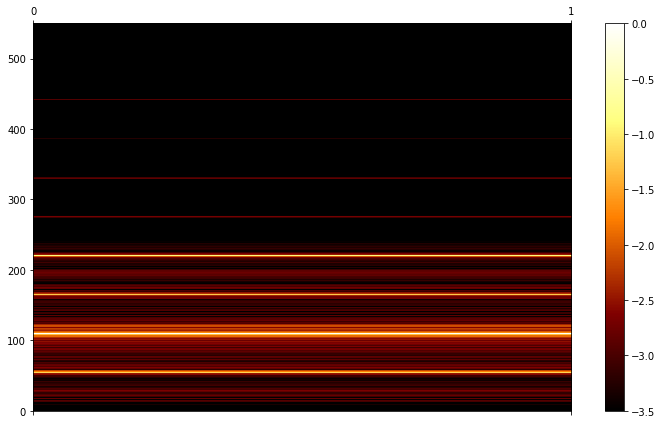

In [424]:
fundamental_freq = 55  # A1
max_freq = 10 * fundamental_freq

print('No filter')
# Load and play audio
piano.load_audio(start=1)
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.5)
piano.plot_spectrogram(piano.spectrogram, max_freq=max_freq)

print('Low-pass filter:')
# Load and play audio - with lowpass filter
piano.load_audio(start=1, butter=(0, 110, 'lowpass'))
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.5)
piano.plot_spectrogram(piano.spectrogram, max_freq=max_freq)

# 3. Harmonics analysis

Removing all frequencies except the harmonics of the fundamental frequency:

- The guitar sounds roughly the same (just a bit more like a pure sine-wave oscillator)
- The piano sounds very different (kind of like a chime or square wave)


This shows:

- That a guitar note has a lot of energy in the harmonics themselves
- That a piano note has a lot of extra energy in the frequencies around its harmonics

N.B. Setting the same amplitude to all of the harmonics (0dB - maximum) sounds like a sawtooth wave. This demonstrates that the relative amplitudes of the harmonics has an important role in determining the final sound.

## Guitar

All frequencies:


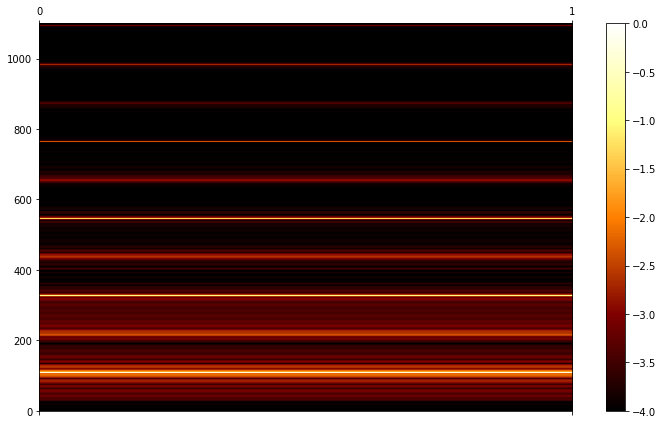

Harmonics only:


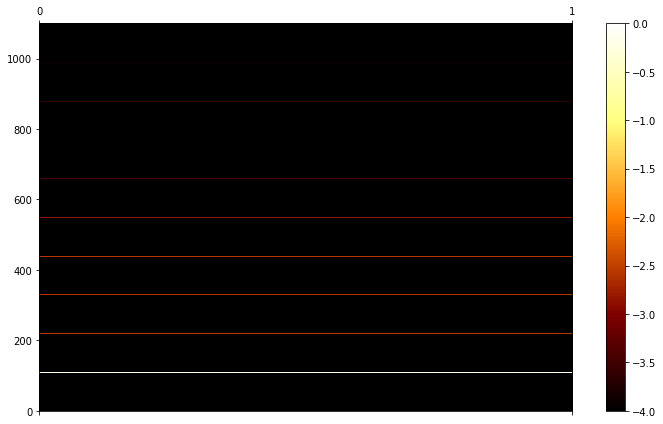

In [422]:
fundamental_freq = 110  # A2
max_freq = 10 * fundamental_freq
neighbour_radius = 4

print('All frequencies:')
# Load audio and create spectrogram
guitar.load_audio(start=0.5)
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, max_freq=max_freq)
guitar.spectrogram_to_audio(guitar.spectrogram)

print('Harmonics only:')
# Create spectrogram which only contains the harmonics
guitar.filter_harmonics(fundamental_freq, neighbour_radius)
guitar.plot_spectrogram(guitar.spectrogram_harm, max_freq=max_freq)
guitar.spectrogram_to_audio(guitar.spectrogram_harm)

## Piano

All frequencies:


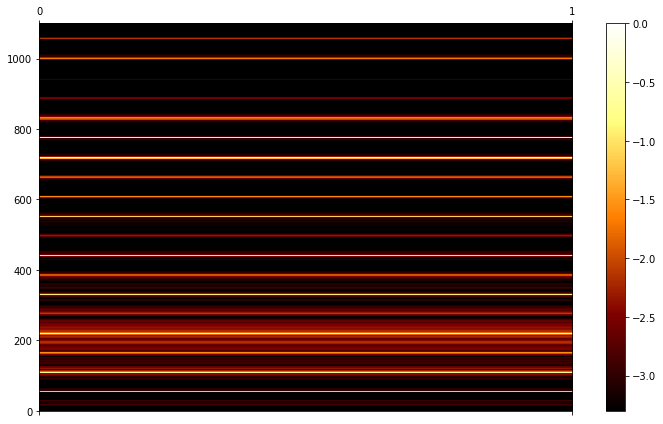

Harmonics only:


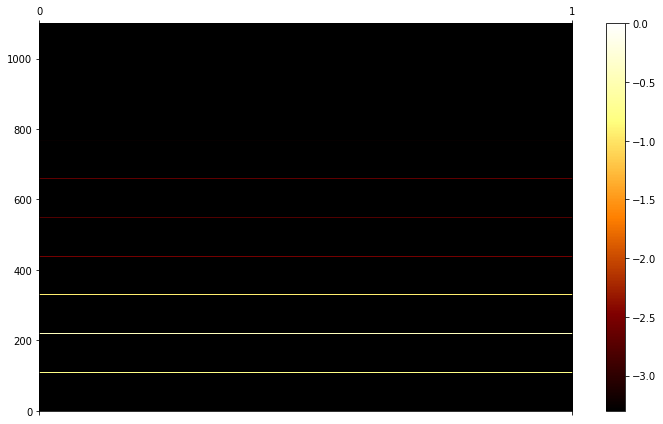

In [423]:
fundamental_freq = 110  # A2
max_freq = 10 * fundamental_freq
neighbour_radius = 4

print('All frequencies:')
# Load audio and create spectrogram
piano.load_audio(start=1)
piano.audio_to_spectrogram(spec_thresh=3.3)
piano.plot_spectrogram(piano.spectrogram, max_freq=max_freq)
piano.spectrogram_to_audio(piano.spectrogram)

print('Harmonics only:')
# Create spectrogram which only contains the harmonics
piano.filter_harmonics(fundamental_freq, neighbour_radius)
piano.plot_spectrogram(piano.spectrogram_harm, max_freq=max_freq)
piano.spectrogram_to_audio(piano.spectrogram_harm)